In [ ]:
from torchvision import models
from torchvision import transforms
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

In [ ]:
transforms = T.ToPILImage()

In [ ]:
class VGG19_(nn.Module):
    def __init__(self):
        """
            Select conv1_1 ~ conv5_1 activation maps
        """
        super(VGG19_, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg19 = models.vgg19(pretrained = True).features

    def forward(self, x):
        """
            Extract multiple convolutional feature maps
        """
        features = []
        for name, layer in self.vgg19._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [ ]:
def load_image(image_path, transform = None, max_size = None, shape = None) -> torch.Tensor:
    """
        Load an image and convert it to torch tensor
    """
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    if transform:
        image = transform(image).unsqueeze(0)
    return image.to(device)

In [ ]:
contents = ["content1.jpg", "content2.jpeg", "content3.jpeg", "content4.jpg"]
styles = ["style.png", "style2.png", "style3.jpeg", "style4.png", "style5.jpg"]
style_names = ["HappyTears", "TusneldaSandersPortrait", "TheStarryNight", "TheScream", "SelfPortraitWithStrawHat"]
contents_names = ["Superman", "StarLord", "Thor", "Groot"]
contents_indicator = 2
styles_indicator = 3

In [ ]:

config = {
    "content": contents[contents_indicator],
    "style": styles[styles_indicator],
    "max_size": 1000, # From 500 it's already good enough
    "total_step": 4000,
    "log_step": 500,
    "sample_step": 500,
    "style_weight": 200, # 100
    "lr": 0.003,
    "save_dir": f'results/'
}

In [ ]:
output_images = {}
content = load_image(config["content"], transform, max_size = config["max_size"])
style = load_image(config["style"], transform, shape = [content.size(2), content.size(3)])
target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr = config["lr"], betas = [0.5, 0.999])
vgg = VGG19_().to(device).eval()

/root/.ipykernel/1482/command-2974213619327241-3912695995:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)
/root/.ipykernel/1482/command-2974213619327241-3912695995:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(shape, Image.LANCZOS)


In [ ]:
for step in range(config["total_step"]):
  target_features = vgg(target)
  content_features = vgg(content)
  style_features = vgg(style)
  style_loss = 0
  content_loss = 0

  for f1, f2, f3 in zip(target_features, content_features, style_features):
      # Compute content loss with target and content images
      content_loss += torch.mean((f1 - f2) ** 2)
      # Reshape convolutional feature maps
      _, c, h, w = f1.size()
      f1 = f1.view(c, h * w)
      f3 = f3.view(c, h * w)
      # Compute gram matrix
      f1 = torch.mm(f1, f1.t())
      f3 = torch.mm(f3, f3.t())
      # Compute style loss with target and style images
      style_loss += torch.mean((f1 - f3) ** 2) / (c * h * w)
  # Compute total loss, backprop and optimize
  loss = content_loss + config["style_weight"] * style_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (step+1) % config["log_step"] == 0:
      print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}'.format(step + 1, config["total_step"], content_loss.item(), style_loss.item()))
  if (step+1) % config["sample_step"] == 0:
      # Save the generated image
      denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
      img = target.clone().squeeze()
      img = denorm(img).clamp_(0, 1)
      output_images['output-{}.png'.format(step + 1)] = img
      # torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Step [500/4000], Content Loss: 22.4957, Style Loss: 117.6695
Step [1000/4000], Content Loss: 23.3656, Style Loss: 43.1164
Step [1500/4000], Content Loss: 23.7861, Style Loss: 24.2565
Step [2000/4000], Content Loss: 24.0756, Style Loss: 15.3455
Step [2500/4000], Content Loss: 24.3033, Style Loss: 10.2841
Step [3000/4000], Content Loss: 24.4905, Style Loss: 7.1991
Step [3500/4000], Content Loss: 24.6508, Style Loss: 5.2408
Step [4000/4000], Content Loss: 24.8020, Style Loss: 3.9539


In [ ]:
output_images.keys()

dict_keys(['output-500.png', 'output-1000.png', 'output-1500.png', 'output-2000.png', 'output-2500.png', 'output-3000.png', 'output-3500.png', 'output-4000.png'])

In [ ]:
imagesPIL = [Image.open(config["content"]), transforms(output_images["output-4000.png"])]
# imagesPIL += [transforms(image_object) for name, image_object in output_images.items()]

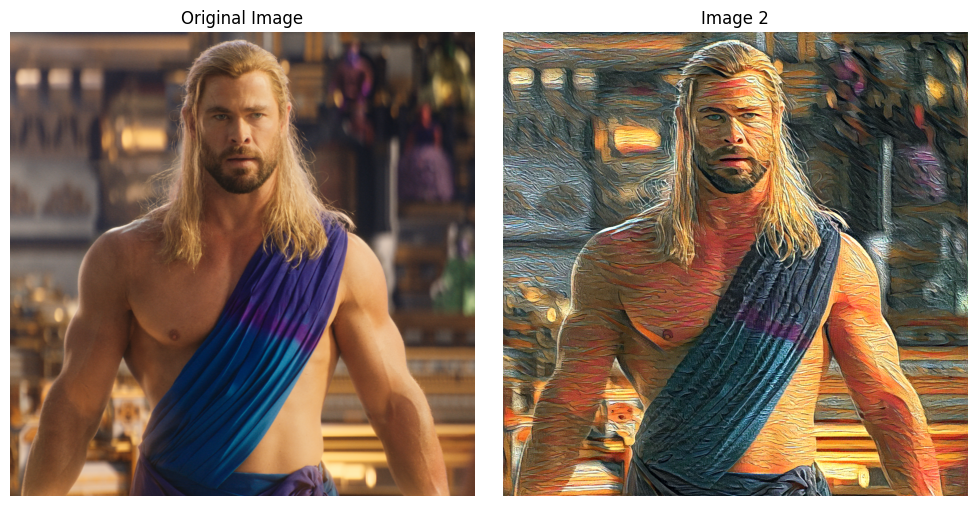

In [ ]:
num_images = len(imagesPIL)
max_images_per_row = 4

num_rows = (num_images + max_images_per_row - 1) // max_images_per_row
num_cols = min(num_images, max_images_per_row)

fig, axes = plt.subplots(num_rows, num_cols, figsize = (10, 5))

if num_rows == 1:
    # Convert axes to a 2D NumPy array to make it 2D
    axes = axes.reshape(1, -1)

for i, img in enumerate(imagesPIL):
    row = i // max_images_per_row
    col = i % max_images_per_row
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    if i == 0:
        axes[row, col].set_title(f'Original Image')
    else:
        axes[row, col].set_title(f'Image {i + 1}')

plt.tight_layout()
plt.show()

In [ ]:
__path = f'{config["save_dir"]}{contents_names[contents_indicator]}_{style_names[styles_indicator]}.png'
torchvision.utils.save_image(output_images["output-4000.png"], __path)
__path